# Init

## load modules

In [256]:
import os
import sys

    
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from PIL import Image, ImageDraw

import radii as radi
import transformTools as tr
import numpy as np
import SimpleITK as sitk
import matplotlib
#matplotlib.use('TkAgg')
import plotly 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import Interface as I
from getting_started import getting_started_dir

#%matplotlib inline

## draw_line()

In [249]:
def draw_line_from_point_to_point(draw, p1, p2):
    draw.line((p1[0], p1[1], p2[0], p2[1]),fill=(255,101,80,40), width=2)

def drawLine(image, rays):
    
    im = Image.open(image).convert("RGBA")
    draw = ImageDraw.Draw(im) 
 
    #draw.line((backCounterPoint[0], backCounterPoint[1], frontCounterPoint[0], frontCounterPoint[1]), fill=200, width=5)
    for rayIndex, ray in enumerate(rays):
        p1 = np.array(ray[0])
        p2 = np.array(ray[-1])
        if (ray[0]==[] or ray[-1]==[]):
            continue
        v = p2-p1
        center = v/2.0
        p11 = p1+1.0*v
        p12 = p1+1.0*v
        
        draw.text((0,0),"lines next to the numbers are showing front rays",fill=(255,255,255,128))
        draw.text((ray[-1][0], ray[-1][1]),str(rayIndex),fill=(255,255,255,128))
        #draw.line((ray[0][0], ray[0][1], ray[-1][0], ray[-1][1]),fill=(255,101,80,1), width=2)
        draw_line_from_point_to_point(draw, p1, p11)
        draw_line_from_point_to_point(draw, p12, p2)
        #draw.line((center[0], ray[0][1], ray[-1][0], ray[-1][1]),fill=(255,101,80,1), width=2)
        #draw.line((ray[0][0], ray[0][1], ray[-1][0], ray[-1][1]),fill=(255,101,80,1), width=2)
    im.show()

    #im.save(sys.stdout, "PNG")
    

## plotCircularProfiles()

In [231]:
def plotCircularProfiles(raysProfileList, selectedProfileIndex):
    

 #   t1 = np.arange(0.0, 5.0, 0.1)
    length = len(raysProfileList)
    #plt.figure(1)
    plt.figure(figsize=(10,18))
    
    for rayIndex, ray in enumerate(raysProfileList[0:length]):
        l = len(ray)*0.092
        x = np.arange(-l/2.0, l/2.0, 0.092)
        plt.subplot(len(raysProfileList),1, rayIndex+1)
        
        #plt.subplot(len(raysProfileList),1, rayIndex+1, frameon=False)
        #plt.axis('off')  
        plt.plot(x,ray,label=str(rayIndex), c = 'r' if rayIndex == selectedProfileIndex else 'k')
        assert(len(ray) % 2 == 1)
        id_mid_point = int((len(ray)-1)/2)
        plt.plot(0, ray[id_mid_point], "o")
        plt.legend()
        plt.tight_layout()
    plt.show() 


## plotRayBurstLines()

In [225]:
def plotRayBurstLines(raysProfileList, selectedProfileIndex):
    

 #   t1 = np.arange(0.0, 5.0, 0.1)
    length = len(raysProfileList)
    #plt.figure(1)
    plt.figure(figsize=(10,18))
    
    for rayIndex, ray in enumerate(raysProfileList[0:length]):
        l = len(ray)*0.092
        x = np.arange(-l/2.0, l/2.0, 0.092)
        plt.subplot(len(raysProfileList),1, rayIndex+1)
        
        #plt.subplot(len(raysProfileList),1, rayIndex+1, frameon=False)
        #plt.axis('off')  
        plt.plot(x,ray,label=str(rayIndex), c = 'r' if rayIndex == selectedProfileIndex else 'k')
        assert(len(ray) % 2 == 1)
        id_mid_point = int((len(ray)-1)/2)
        plt.plot(0, ray[id_mid_point], "o")
        plt.legend()
        plt.tight_layout()
    plt.show() 


## statistics()

In [134]:
def statistics(pos, inputImage, inputTifImage):
    rays, raysProfiles = radiusCalculator.getProfileAtThisPoint(inputImage, pos)
    
    selectedBackProfile, selectedFrontProfile, radiusList,\
    minRadius, BackCountorPoint, frontCounterPoint,\
    counterList,raysProfiles_1, rays, selectedProfileIndex = radiusCalculator.getRadiusFromProfile(inputImage, pos)
    
    drawLine(inputTifImage, rays)
    drawLine(inputTifImage, counterList)
    print 'minRadius: ', minRadius 
    plotCircularProfiles(raysProfiles, selectedProfileIndex)

## collectRadii()

In [5]:
def collectRadii(points, cutOffValues, numberOfRays, inputImage, postMeasurment='no' ): 
    radiiSet = []
    for cutOff in cutOffValues:
       
        radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                                 zResolution=0.5,
                                                 xySize=20,
                                                 numberOfRays=numberOfRays,
                                                 tresholdPercentage=cutOff)
        radii = radiusCalculator.getProfileOfThesePoints(inputImage, points, postMeasurment)
         
        radiiSet.append(radii)
        del radiusCalculator
    return radiiSet


## scatterPlot()

In [6]:
def scatterPlot(radiiData, style = 'scatter'):

    g1 = radiiData[0]
    g2 = radiiData[1]
    g3 = radiiData[2]
    
    gLen = len(g1)
    area = 30
    
    data = (g1, g2, g3)
    colors = ("red", "green", "blue")
    groups = ("0.25", "0.5", "0.75")
     
   
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
 
    for data, color, group in zip(data, colors, groups):
        x = np.arange(0, gLen, 1)
        y = data
        if style == 'scatter':
            ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=area, label=group)
        elif style == 'line':
            ax.plot(x, y, c=color, label=group)


    plt.title('radius scatter plot')
    plt.legend(loc=2)
    plt.savefig('scatter.png', bbox_inches='tight')
    plt.show()

In [7]:
def get_modified_points(points, inputImage):
    radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                                 zResolution=0.5,
                                                 xySize=20,
                                                 numberOfRays=20,
                                                 tresholdPercentage=0.5)

    radiusCalculator.debug_postMeasurementPoints = []
    radiusCalculator.getProfileOfThesePoints(inputImage, points, 'yes')
    return radiusCalculator.debug_postMeasurementPoints

## optional: switches on clicking mode

In [203]:

imgArray = sitk.GetArrayViewFromImage(inputImage)

f,imgplot=plt.subplots()
imgplot = plt.imshow(imgArray);

pos = []
def onclick(event):
    pos = []
    pos.append([event.xdata,event.ydata])
    statistics(pos[0])

f.canvas.mpl_connect('button_press_event', onclick)
f.show()

# Load Data

## Setup ModelDataBase

In [8]:
mdb = I.ModelDataBase('/nas1/Data_anajafgholi/results/20190410_profiling')

## Full structure

In [ ]:
inputTifImage_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/tif/max_z_projections','S13_max_z_projection.tif')
inputAmData_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am','S13_final_done_Alison_zScale_40.am')
outputAmData025_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output','S13_withRadius025.am')
outputAmData05_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output','S13_withRadius05.am')
outputAmData075_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output','S13_withRadius075.am')

In [ ]:
imageFileReader = sitk.ImageFileReader()
imageFileReader.SetFileName(inputTifImage_s13)
inputImage_s13 = imageFileReader.Execute()

## Axon only

In [ ]:
inputTifImageAxon_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/tif/max_z_projections','S13_max_z_projection.tif')
inputAmDataAxon_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_analysis','S13_final_done_Alison_zScale_40_axon.am')

In [ ]:
imageFileAxonReader = sitk.ImageFileReader()
imageFileAxonReader.SetFileName(inputTifImageAxon_s13)
inputImageAxon_s13 = imageFileAxonReader.Execute()

## Dendrite only

In [ ]:
inputTifImageDendrite_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/tif/max_z_projections','S13_max_z_projection.tif')
inputAmDataDendrite_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_analysis','S13_final_done_Alison_zScale_40_dendrite.am')

In [ ]:
imageFileDendriteReader = sitk.ImageFileReader()
imageFileDendriteReader.SetFileName(inputTifImageDendrite_s13)
inputImageDendrite_s13 = imageFileDendriteReader.Execute()

## Apical S24

In [9]:
inputTifImage_S24 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/tif/max_z_projections','S24_max_z_projection.tif')
inputAmData_S24 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am/','S24_final_done_Alison_zScale_40.am')

In [10]:
imageFileReader_S24 = sitk.ImageFileReader()
imageFileReader_S24.SetFileName(inputTifImage_S24)
inputImage_S24 = imageFileReader_S24.Execute()

# Get spatial points

## Full structure - Spatial Points

In [ ]:
points = radi.spacialGraph.getSpatialGraphPoints(inputAmData_s13)
points = mdb.maybe_calculate('points', lambda: map(lambda x: map(lambda y: int(y/0.092), x), points))
radiiSet = mdb.maybe_calculate('radiiSet', lambda: collectRadii(points, [0.25, 0.5, 0.75], 10))

In [ ]:
modified_points = get_modified_points(points)

In [ ]:
intensity_at_point = [inputImage_s13.GetPixel(point) for point in points]

In [ ]:
intensity_at_modified_points = [inputImage_s13.GetPixel(point) for point in modified_points]

## Axon - Spatial Points

In [ ]:
points_axon = radi.spacialGraph.getSpatialGraphPoints(inputAmDataAxon_s13)
points_axon = mdb.maybe_calculate('points_axon', lambda: map(lambda x: map(lambda y: int(y/0.092), x), points_axon))
radiiSetAxon = mdb.maybe_calculate('radiiSet_axon', lambda: collectRadii(points_axon, [0.25, 0.5, 0.75], 10))

In [ ]:
intensity_at_point_axon = [inputImageAxon_s13.GetPixel(point) for point in points_axon]

In [ ]:
modified_axonPoints = get_modified_points(points_axon)

In [ ]:
intensity_at_modified_axon_points = [inputImageAxon_s13.GetPixel(point) for point in modified_axonPoints]

## Dendrite - Spatial Points

In [ ]:
points_dendrite = radi.spacialGraph.getSpatialGraphPoints(inputAmDataDendrite_s13)
points_dendrite = mdb.maybe_calculate('points_dendrite', lambda: map(lambda x: map(lambda y: int(y/0.092), x), points_dendrite))
radiiSetDendrite = mdb.maybe_calculate('radiiSet_dendrite', lambda: collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10))

In [ ]:
intensity_at_point_dendrite = [inputImageAxon_s13.GetPixel(point) for point in points_dendrite]

In [ ]:
modified_dendritePoints = get_modified_points(points_dendrite)

In [ ]:
intensity_at_modified_dendrite_points = [inputImageAxon_s13.GetPixel(point) for point in modified_dendritePoints]

## Apical S24 Spatial Points

In [115]:
points_S24 = radi.spacialGraph.getSpatialGraphPoints(inputAmData_S24)
points_S24 = mdb.maybe_calculate('points_S24', lambda: map(lambda x: map(lambda y: int(y/0.092), x), points_S24))
radiiSet_S24 = mdb.maybe_calculate('radiiSet_S24', lambda: collectRadii(points_S24, [0.25, 0.5, 0.75], 10, inputImage_S24, postMeasurment="yes") )

In [92]:
intensity_at_point_S24 = [inputImage_S24.GetPixel(point) for point in points_S24]

In [93]:
modified_Points_S24 = get_modified_points(points_S24, inputImage_S24)

In [94]:
intensity_at_modified_points_S24 = [inputImage_S24.GetPixel(point) for point in modified_Points_S24]

# Extract radii

## Full structure

### Full structure - first measurment

In [ ]:
#temp = collectRadii(points, [0.25, 0.5, 0.75], 10, 'no')

In [ ]:
#mdb['radiiSet'] = temp

In [ ]:
radiiSet = mdb.maybe_calculate('radiiSet', lambda: collectRadii(points, [0.25, 0.5, 0.75], 10, 'no'))

### Full structue - post Measurment

In [ ]:
##temp_post = collectRadii(points, [0.25, 0.5, 0.75], 10, 'yes')

In [ ]:
##mdb['postRadiiSet'] = temp_post

In [ ]:
postRadiiSet = mdb.maybe_calculate('postRadiiSet', lambda: collectRadii(points, [0.25, 0.5, 0.75], 10, 'yes'))

In [ ]:
radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                                 zResolution=0.5,
                                                 xySize=20,
                                                 numberOfRays=20,
                                                 tresholdPercentage=0.5)

radiusCalculator.debug_postMeasurementPoints = []

## Axon Only

### Axon only - first measurment

In [ ]:
#temp_axon = collectRadii(points_axon, [0.25, 0.5, 0.75], 10, 'no')

In [ ]:
#mdb['radiiSetAxon'] = temp_axon

In [ ]:
postRadiiSetAxon = mdb.maybe_calculate('radiiSetAxon', lambda: collectRadii(points_axon, [0.25, 0.5, 0.75], 10, 'no'))

### Axon only - post measurment

In [ ]:
#tempPost_axon = collectRadii(points_axon, [0.25, 0.5, 0.75], 10, 'yes')

In [ ]:
#mdb['postRadiiSetAxon'] = tempPost_axon

In [ ]:
postRadiiSetAxon = mdb.maybe_calculate('postRadiiSetAxon', lambda: collectRadii(points_axon, [0.25, 0.5, 0.75], 10, 'yes'))

## Dendrite only

### Dendrite only - first measurment

In [ ]:
#temp_dendrite = collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10, 'no')

In [ ]:
#mdb['radiiSetDendrite'] = temp_dendrite

In [ ]:
radiiSetDendrite = mdb.maybe_calculate('radiiSetDendrite', lambda: collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10, 'no'))

### Dendrite only - post measurment

In [ ]:
#tempPost_dendrite = collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10, 'yes')

In [ ]:
#mdb['postRadiiSetDendrite'] = tempPost_dendrite

In [ ]:
postRadiiSetDendrite = mdb.maybe_calculate('postRadiiSetDendrite', lambda: collectRadii(points_dendrite, [0.25, 0.5, 0.75], 10, 'yes'))

## Apical S24

In [117]:
RadiiSet_S24 = mdb.maybe_calculate('RadiiSet_S24', lambda: collectRadii(points_S24, [0.25, 0.5, 0.75], 10, inputImage_S24,'no'))

In [118]:
postRadiiSet_S24 = mdb.maybe_calculate('postRadiiSet_S24', lambda: collectRadii(points_S24, [0.25, 0.5, 0.75], 10, inputImage_S24,'yes'))

# Analysis

## Create radiusCalculator Object

In [254]:
radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                         zResolution=0.5,
                                         xySize=20,
                                         numberOfRays=10,
                                         tresholdPercentage=0.50)

### Put any new morphology to the postRadiiSet array

In [233]:
radiiSet = RadiiSet_S24
postRadiiSet = postRadiiSet_S24
inputImage = inputImage_S24
inputTifImage = inputTifImage_S24
intensity_at_modified_points = intensity_at_modified_points_S24
modified_Points = modified_Points_S24
intensity_at_point = intensity_at_point_S24

## Get points with special intensities

In [194]:
[points[idx] for idx, p in enumerate(postRadiiSet[0]) if p == 100]

[]

## Debugging: how does a single point get updated?

In [234]:
point_original = [3142, 3160] # [195, 560, 0] # [2740, 568, 227]
_, _, _, _, _, _, _, raysProfileList, rays, _ = radiusCalculator.getRadiusFromProfile(inputImage, point_original, postMeasurment='no')

In [235]:
point_original = [3142, 3160, 0]

In [236]:
point_modified = radiusCalculator.postMeasurmentFunction(inputImage, rays, raysProfileList)
_, _, _, radius, _, _, _, _, _, _ = radiusCalculator.getRadiusFromProfile(inputImage, point_modified, postMeasurment='no')

In [237]:
intensity_at_point = [inputImage.GetPixel(point) for point in points_S24]

In [216]:
radius*0.092

5.3367930445165292

In [250]:
print point_original
print point_modified

[3142, 3160, 0]
[3122, 3160]


minRadius:  46.1735855225


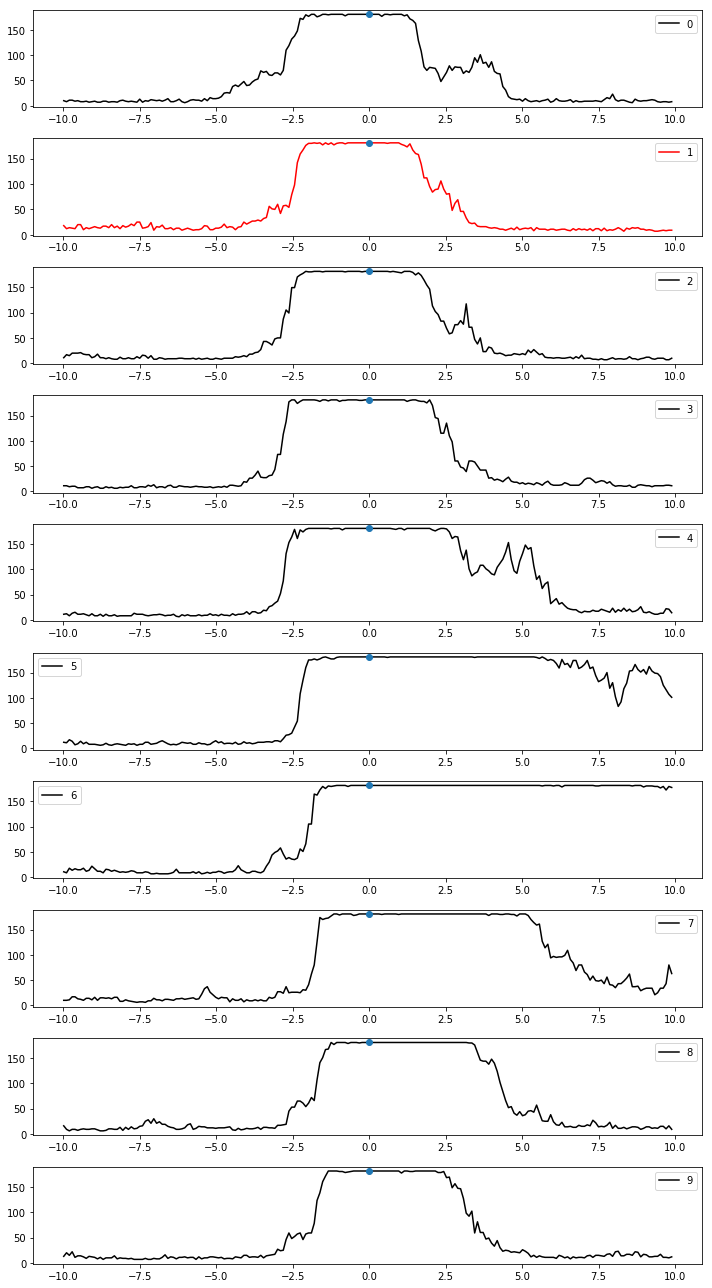

In [255]:
statistics(point_original, inputImage_S24, inputTifImage)

In [240]:
%debug

> <ipython-input-230-94e89c90a752>(15)drawLine()
     13         if (p1 == [] or p2 == []):
     14             continue
---> 15         v = p2-p1
     16         center = v/2.0
     17         p11 = p1+1.0*v

ipdb> rays
[[[3101, 3160], [3189, 3160]], [[3114, 3169], [3174, 3150]], [[3116, 3179], [3172, 3138]], [[3124, 3185], [3161, 3133]], [[3133, 3189], [3161, 3100]], [[3142, 3185], []], [[3149, 3182], []], [[3153, 3176], [3094, 3093]], [[3163, 3175], [3101, 3131]], [[3169, 3168], [3102, 3147]]]

KeyboardInterrupt


In [219]:
statistics(point_modified, inputImage, inputTifImage)

ValueError: operands could not be broadcast together with shapes (0,) (2,) 

In [156]:
pdf = I.pd.DataFrame(radiiSet).T*0.092

In [157]:
ppdf = I.pd.DataFrame(postRadiiSet).T*0.092

## Dark point on axon, sligthly beside structure

In [ ]:
radiusCalculator.tresholdPercentage = 0.8

In [ ]:
statistics([2740, 568, 227])

In [ ]:
statistics(point)

# Intensity Distribution Structure vs. Background

In [158]:
def get_random_point(image, n):
    dim = image.GetSize()
    intensities = []
    for n in range(n):
        point = [I.np.random.randint(0, dim[0]), I.np.random.randint(0, dim[1])]
        intensities.append(image.GetPixel(point))
    return intensities

## Full structure - First Measurment

In [133]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_point, bins = bins, label = 'Full-First Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Full structure - Post Measurment

In [58]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_modified_points, bins = bins, label = 'Full-Post Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Axon vs. Background - First Measurment

In [59]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_point_axon, bins = bins, label = 'Axon-First Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


NameError: name 'intensity_at_point_axon' is not defined

## Axon vs. Background - Post Measurment

In [ ]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_modified_axon_points, bins = bins, label = 'Axon-Post Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Dendrite vs. Background - First Measurment

In [ ]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_point_dendrite, bins = bins, label = 'Dendrite-First Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Dendrite vs. Background - Post measurment

In [ ]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_modified_dendrite_points, bins = bins, label = 'Dendrite-Post Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


## Apical vs. Background - Post measurment

In [88]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_modified_points, bins = bins, label = 'Full-Post Meas.', color = 'r')
_ = I.plt.hist(get_random_point(inputImage, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


# ScatterPlot

## Full Structure - First Measurment

In [ ]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, radiiSet))

## Full Structure - Post Measurment

In [ ]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, postRadiiSet))

## Axon - First Measurment

In [ ]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, radiiSetAxon))

## Axon - Post Measurment

In [ ]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, postRadiiSetAxon))

## Dendrite - First Measurment

In [ ]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, radiiSetDendrite))

## Dendrite - Post Measurment

In [ ]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, postRadiiSetDendrite))

## scatterplot of bright (>100) structure

In [ ]:
pdf = I.pd.DataFrame(radiiSet).T*0.092

In [ ]:
pdf['intensity'] = intensity_at_point

In [ ]:
selected_pdf = pdf[pdf.intensity > 45]

In [ ]:
radiiSet_selected = map(lambda columnname: list(selected_pdf[columnname]), [0,1,2])

In [ ]:
scatterPlot(radiiSet_selected)

## Scatter Plot for Apical S24

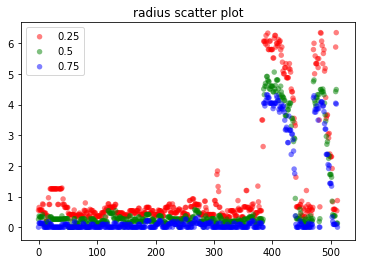

In [71]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, postRadiiSet))

# Errors, PDF

## Full struc. Ppdf and Pdf

In [76]:
ppdf['intensity'] = intensity_at_modified_points

In [77]:
def error_vs_success_rate(ppdf):
    ppdf['error'] = ppdf[0] - ppdf[2]
    _ = I.plt.hist(ppdf.error, bins = I.np.arange(0, 8, .01), cumulative = True, normed = True)
    I.sns.despine()
    I.plt.xlabel('error / micron')
    I.plt.ylabel('frac. successful radius estimates')

In [78]:
error_vs_success_rate(ppdf)
error_vs_success_rate(pdf)
I.plt.axvline(1, c = 'k')
I.plt.figure(figsize=(8,8))

NameError: name 'pdf' is not defined

In [ ]:
I.plt.plot(ppdf.intensity, ppdf.error, 'o')
I.plt.xlabel('brightness')
I.plt.ylabel('error / micron')
I.sns.despine()

In [ ]:
pdf[1].plot(kind='hist')

In [ ]:
ppdf.error.plot(kind = 'hist')

In [ ]:
ppdf_selected = ppdf[ppdf.intensity > 0]
I.plt.hist(ppdf_selected[0]-ppdf_selected[2])

In [ ]:
bins = I.np.arange(0,10,.1)
out = []
for intensity_cutoff in range(0,200,1):
    pdf_selected = pdf[pdf.intensity > intensity_cutoff]
    out.append(I.np.histogram(pdf_selected[0]-pdf_selected[2], bins = bins, normed = True)[0])

In [ ]:
error_pdf = I.pd.DataFrame(out, index = range(0,200,1), columns = bins[:-1])
error_pdf.index.name = 'intensity_cutoff'
error_pdf = error_pdf.T
error_pdf.index.name = 'error / micron'
error_pdf = error_pdf.iloc[::-1]


In [ ]:
%matplotlib inline

In [ ]:
postRadiiSet

In [ ]:
len(radiiSet[0])

In [ ]:
I.sns.heatmap(error_pdf, vmax=.1)

In [ ]:
I.sns.heatmap(error_pdf, vmax=.1)

In [ ]:
bins = I.np.arange(0,10,.1)
out = {}
for intensity_cutoff in range(0,200,1):
    pdf_selected = pdf[pdf.intensity > intensity_cutoff]
    out[intensity_cutoff] = len(pdf_selected) / float(len(pdf))

In [ ]:
I.pd.Series(out).plot()

In [ ]:
out[50]

# For Amira Visualization

In [ ]:
radi.spacialGraph.write_spacial_graph_with_thickness(inputAmData_s13, outputAmData025_s13, radiiSet[0])
radi.spacialGraph.write_spacial_graph_with_thickness(inputAmData_s13, outputAmData05_s13, postRadiiSet[1])
radi.spacialGraph.write_spacial_graph_with_thickness(inputAmData_s13, outputAmData075_s13, radiiSet[2])

# Full Morphology Analysis

## Load data

In [257]:
inputAmFolder = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am/')
outputAmFolder050 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output/050/')
outputAmFolder025 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output/025/')
outputAmFolder075 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output/075/')
outputAmFolder050WithError = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output/050WithError/')
outputAmFolder050WithRadAndError = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output/050WithRadAndError/')
outputAmFolderError = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am_output/amWithError/')
inputTifImages = I.os.path.join(getting_started_dir, 'radii/data/neuron1/tif/max_z_projections/')

## Full morphology with 0.5 treshold

## Full morphology with 0.25 treshold

## Full morphology with 0.75 treshold

## Write Am with radius and Error bars

### Read all am points

In [ ]:
amFolderWithRadius050 = outputAmFolder050
amFolderWithRadius025 = outputAmFolder025
amFolderWithRadius075 = outputAmFolder075

From Here points will be a dictionary containe radius and uncertainty and etc.

In [ ]:
allAmPointsWithRadius050, points050 = tr.read.multipleAmFiles(amFolderWithRadius050)
allAmPointsWithRadius025, points025 = tr.read.multipleAmFiles(amFolderWithRadius025)
allAmPointsWithRadius075, points075 = tr.read.multipleAmFiles(amFolderWithRadius075)

### Calculate the uncertainitcy (error bars) for all points in a one array

In [ ]:
numberOfPoints = len(allAmPointsWithRadius050)
uncertainties = [(allAmPointsWithRadius025[idx][3] - allAmPointsWithRadius075[idx][3]) for idx in range(numberOfPoints)]

### Calculate the uncertainitcy (error bars) section by section and add them to the points object

In [ ]:
amFiles050WithUncertainty = radi.calcError.addUncertainties(points050, points025, points075)

### Write the uncertainty to a one big final am file

In [ ]:
inputAmTemplateFile = outputAmFolderError + "template.am"
outputAmWithRadiusAndUncertainty = outputAmFolderError + "s_radiiAndUncertainties.am"

In [ ]:
tr.write.amFileWithRadiusAndUncertainty(inputAmTemplateFile, 
                                        outputAmWithRadiusAndUncertainty, 
                                        allAmPointsWithRadius050, uncertainties)

### add the uncertainty to the mulitple am files

In [ ]:
tr.write.multipleAmFilesWithRadiusAndUncertainty(inputAmFolder, 
                                        outputAmFolder050WithError, 
                                        amFiles050WithUncertainty)

### add the uncertainty and radius to the same am file and run this for all am files 

In [ ]:
tr.write.multipleAmFilesWithRadiusAndUncertainty(inputAmFolder, 
                                        outputAmFolder050WithRadAndError, 
                                        amFiles050WithUncertainty)

In [ ]:
numberOfPoints

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np

#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/iris.csv')
#df.head()

x = pd.Series([point[0] for point in allAmPointsWithRadius050])
y = pd.Series([point[1] for point in allAmPointsWithRadius050])
z = pd.Series([point[2] for point in allAmPointsWithRadius050])

#x = ([point[0] for point in allAmPointsWithRadius050])
#y = ([point[1] for point in allAmPointsWithRadius050])
#z = ([point[2] for point in allAmPointsWithRadius050])

trace = go.Scatter3d(
    x=x, y=y, z=z,
    marker=dict(
        size=4,
        color=z,
        colorscale='Viridis',
    ),
    line=dict(
        color='#1f77b4',
        width=1
    )
)

data = [trace]

layout = dict(
    width=2000,
    height=2000,
    autosize=True,
    title='Spactial Data point',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig = dict(data=data, layout=layout)

plotly.offline.plot(fig, filename='spatial-graphes')
print("hi")